In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
path = "/content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset"

In [32]:
! ls $path

Europe_Mask.tif  output_data  polygonOfInterest.txt


In [ ]:
!pip install earthengine-api geemap rasterio patchify

# Sentinel-2 Data Processing Pipeline

## This notebook processes Sentinel-2 data for machine learning applications, including:
## - Processing multi-band satellite imagery
## - Creating binary masks from reference data
## - Tiling both for deep learning applications

Sentinel Data Processing Pipeline:

This notebook processes Sentinel-2 and Sentinel-1 data and reference masks for the specified German region:
1. Reads existing Sentinel-2 bands from JP2 files
2. Resamples all bands to 20m resolution to form a stack
3. Processes the reference mask
4. Creates a numpy array (5490,5490,12) for Sentinel-2 images
5. Tiles the data using patchify to patches (128x128)
6. Creates binary masks from reference data
7. Exports numpy arrays (5490,5490,1) for labeled data
8. Tiles the labeled data to 128x128





In [33]:
# Import necessary libraries
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from patchify import patchify
import rasterio as rio
from rasterio.enums import Resampling
from sklearn.preprocessing import MinMaxScaler
import datetime
import ee
import geemap
import time
from google.colab import files, drive
from IPython.display import Image, display

# Initialize Earth Engine
try:
    ee.Initialize()
except:
    # If authentication is needed
    ee.Authenticate()
    ee.Initialize(project='ee-sherifabdeltawabelsayed')

print("Earth Engine initialized successfully!")

Earth Engine initialized successfully!


In [34]:
# Define parameters
BASE_PATH = "/content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset"  # Base directory for all data
INPUT_DIR = BASE_PATH
OUTPUT_DIR = os.path.join(BASE_PATH, "output_data")
ROI_NAME = "germany_region"
PATCH_SIZE = 128
TARGET_RESOLUTION = 20  # meters
IMG_SIZE = 5490  # Final image size
TARGET_DATE = '2021-09-09'  # Target date
DATE_RANGE = 10  # Days before and after to search if exact date isn't available

In [35]:
# Create output directories
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "raw_data"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "processed_data"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "numpy_arrays"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "patches"), exist_ok=True)

print(f"Directories created in {BASE_PATH}")

Directories created in /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset


##  1. Load Region of Interest (ROI)

In [36]:
# Load area of interest from GeoJSON
def load_roi_geometry():
    """Load region of interest and convert to Earth Engine geometry"""
    # Create the GeoJSON content from the coordinates
    geojson_content = """
    {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "coordinates": [
              [
                [
                  8.339723992559328,
                  53.31999651525345
                ],
                [
                  8.339723992559328,
                  52.504369017415314
                ],
                [
                  9.553721212887297,
                  52.504369017415314
                ],
                [
                  9.553721212887297,
                  53.31999651525345
                ],
                [
                  8.339723992559328,
                  53.31999651525345
                ]
              ]
            ],
            "type": "Polygon"
          }
        }
      ]
    }
    """

    # Save the GeoJSON to a file
    roi_path = os.path.join(INPUT_DIR, 'polygonOfInterest.txt')
    with open(roi_path, 'w') as f:
        f.write(geojson_content)

    print(f"ROI polygon saved to: {roi_path}")

    # Parse the GeoJSON
    geojson = json.loads(geojson_content)

    # Extract coordinates
    coords = geojson['features'][0]['geometry']['coordinates'][0]

    # Convert to Earth Engine geometry format (lng, lat)
    ee_coords = [list(coord) for coord in coords]

    # Create an Earth Engine geometry
    roi = ee.Geometry.Polygon(ee_coords)

    print(f"Created Earth Engine ROI geometry")
    return roi

In [37]:
# Create the geometry and visualize it
roi = load_roi_geometry()

ROI polygon saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/polygonOfInterest.txt
Created Earth Engine ROI geometry


In [38]:
# Create a map centered on the ROI
Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(roi, {'color': 'red'}, 'ROI')
Map

Map(center=[52.91244946812999, 8.94672260272317], controls=(WidgetControl(options=['position', 'transparent_bg…

## 2. Download Sentinel-2 Data from GEE

In [39]:
def download_sentinel2():
    """Download Sentinel-2 imagery from Google Earth Engine"""
    print(f"Searching for Sentinel-2 imagery around {TARGET_DATE}...")

    # Calculate date range
    date_obj = datetime.datetime.strptime(TARGET_DATE, '%Y-%m-%d')
    start_date = (date_obj - datetime.timedelta(days=DATE_RANGE)).strftime('%Y-%m-%d')
    end_date = (date_obj + datetime.timedelta(days=DATE_RANGE)).strftime('%Y-%m-%d')

    print(f"Date range: {start_date} to {end_date}")

    # Get Sentinel-2 collection
    s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                    .filterDate(start_date, end_date)
                    .filterBounds(roi)
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Low cloud coverage
                    .sort('CLOUDY_PIXEL_PERCENTAGE'))

    # Check if any images were found
    count = s2_collection.size().getInfo()
    print(f"Found {count} Sentinel-2 images in date range")

    if count == 0:
        raise Exception("No Sentinel-2 images found for the specified date range and ROI")

    # Select the best image (least cloudy)
    s2_image = s2_collection.first()

    # Get image properties
    image_date = ee.Date(s2_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    cloud_percent = s2_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()

    print(f"Selected S2 image from: {image_date} (Cloud: {cloud_percent:.2f}%)")

    # Select all relevant bands
    bands_to_select = [
        'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'
    ]
    s2_selected = s2_image.select(bands_to_select)

    # Create a true color visualization
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    }

    # Add image to map
    Map.addLayer(s2_selected, vis_params, 'Sentinel-2 Image')

    # Create a thumbnail of the image
    thumbnail_url = s2_selected.getThumbURL({
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'gamma': 1.4,
        'dimensions': 1024,
        'region': roi
    })

    print("Sentinel-2 image preview:")
    display(Image(url=thumbnail_url))

    # Save the thumbnail locally


    # Export image to Google Drive
    export_folder = "0_PrototypeFund_Project"  # Folder within Google Drive
    export_id = f"sentinel2_{ROI_NAME}_{image_date.replace('-', '')}"
    thumbnail_path = os.path.join(OUTPUT_DIR, "processed_data", "sentinel2_preview.png")

    # Set up the export task
    task = ee.batch.Export.image.toDrive(
        image=s2_selected,
        description=export_id,
        folder=export_folder,
        fileNamePrefix=export_id,
        region=roi,
        scale=TARGET_RESOLUTION,
        crs='EPSG:32632',  # UTM zone 32N for the German region
        maxPixels=1e10
    )

    # Start the export
    task.start()
    print(f"Started Sentinel-2 export task with ID: {task.id}")

    # Monitor task progress
    while task.active():
        print(f"Export in progress... State: {task.status()['state']}")
        time.sleep(10)

    print(f"Export completed with status: {task.status()['state']}")

    # Get the file path in Drive
    expected_filename = f"{export_id}.tif"
    output_path = os.path.join(OUTPUT_DIR, "raw_data", expected_filename)

    # Copy the file to the output directory using the copy2 command
    # Note: This is a placeholder - in a real workflow, you'd need to move the file from
    # the Google Drive download location to your output directory
    print(f"Expected file path in Google Drive: /content/drive/MyDrive/{export_folder}/{expected_filename}")
    print(f"Please manually copy this file to: {output_path}")

    return output_path, image_date

# Download Sentinel-2 imagery
s2_filepath, s2_date = download_sentinel2()

Searching for Sentinel-2 imagery around 2021-09-09...
Date range: 2021-08-30 to 2021-09-19
Found 9 Sentinel-2 images in date range
Selected S2 image from: 2021-09-09 (Cloud: 1.01%)
Sentinel-2 image preview:


Started Sentinel-2 export task with ID: 67FERWP4GQ3MCURMWZ3Q4LUF
Export in progress... State: READY
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export completed with status: COMPLETED
Expected 

## 3. Download Sentinel-1 Data from GEE

In [40]:
def download_sentinel1(target_date):
    """Download Sentinel-1 SAR imagery from Google Earth Engine"""
    print(f"Searching for Sentinel-1 imagery around {target_date}...")

    # Calculate date range (wider for S1 to ensure overlap)
    date_obj = datetime.datetime.strptime(target_date, '%Y-%m-%d')
    start_date = (date_obj - datetime.timedelta(days=DATE_RANGE*2)).strftime('%Y-%m-%d')
    end_date = (date_obj + datetime.timedelta(days=DATE_RANGE*2)).strftime('%Y-%m-%d')

    print(f"Date range: {start_date} to {end_date}")

    # Get Sentinel-1 collection
    s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                    .filterDate(start_date, end_date)
                    .filterBounds(roi)
                    .filter(ee.Filter.eq('instrumentMode', 'IW'))
                    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                    .select(['VV', 'VH']))

    # Check if any images were found
    count = s1_collection.size().getInfo()
    print(f"Found {count} Sentinel-1 images in date range")

    if count == 0:
        raise Exception("No Sentinel-1 images found for the specified date range and ROI")

    # Get the image closest to the Sentinel-2 date
    s1_list = s1_collection.toList(s1_collection.size())

    # Find closest image to target date
    target_millis = ee.Date(target_date).millis()

    def calculateTimeDifference(image):
        return ee.Image(image).set(
            'timeDiff',
            ee.Number(ee.Image(image).get('system:time_start')).subtract(target_millis).abs()
        )

    s1_with_diff = ee.ImageCollection(
        s1_list.map(calculateTimeDifference)
    ).sort('timeDiff')

    # Get the image with the smallest time difference
    s1_image = ee.Image(s1_with_diff.first())

    # Get image date
    image_date = ee.Date(s1_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    time_diff_days = abs((datetime.datetime.strptime(image_date, '%Y-%m-%d') -
                         datetime.datetime.strptime(target_date, '%Y-%m-%d')).days)

    print(f"Selected S1 image from: {image_date} ({time_diff_days} days from target)")

    # Create visualization for the map
    vis_params = {
        'bands': ['VV'],
        'min': -25,
        'max': 0
    }

    # Add to map
    Map.addLayer(s1_image, vis_params, 'Sentinel-1 Image')

    # Create a thumbnail preview
    thumbnail_url = s1_image.getThumbURL({
        'bands': ['VV'],
        'min': -25,
        'max': 0,
        'dimensions': 1024,
        'region': roi
    })

    print("Sentinel-1 image preview:")
    display(Image(url=thumbnail_url))



    # Export image to Google Drive
    export_folder = "0_PrototypeFund_Project"  # Folder within Google Drive
    export_id = f"sentinel1_{ROI_NAME}_{image_date.replace('-', '')}"
    # Save the thumbnail locally
    thumbnail_path = os.path.join(OUTPUT_DIR, "processed_data", "sentinel1_preview.png")

    # Set up the export task
    task = ee.batch.Export.image.toDrive(
        image=s1_image,  # Original values, not DB
        description=export_id,
        folder=export_folder,
        fileNamePrefix=export_id,
        region=roi,
        scale=TARGET_RESOLUTION,
        crs='EPSG:32632',  # UTM zone 32N for the German region
        maxPixels=1e10
    )

    # Start the export
    task.start()
    print(f"Started Sentinel-1 export task with ID: {task.id}")

    # Monitor task progress
    while task.active():
        print(f"Export in progress... State: {task.status()['state']}")
        time.sleep(10)

    print(f"Export completed with status: {task.status()['state']}")

    # Get the file path in Drive
    expected_filename = f"{export_id}.tif"
    output_path = os.path.join(OUTPUT_DIR, "raw_data", expected_filename)

    # Copy file to the output directory (placeholder instruction)
    print(f"Expected file path in Google Drive: /content/drive/MyDrive/{export_folder}/{expected_filename}")
    print(f"Please manually copy this file to: {output_path}")

    return output_path, image_date

# Download Sentinel-1 imagery
s1_filepath, s1_date = download_sentinel1(s2_date)

Searching for Sentinel-1 imagery around 2021-09-09...
Date range: 2021-08-20 to 2021-09-29
Found 38 Sentinel-1 images in date range
Selected S1 image from: 2021-09-09 (0 days from target)
Sentinel-1 image preview:


Started Sentinel-1 export task with ID: ZNGGZMB2DQIGFIYUXJR4HOJL
Export in progress... State: READY
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in progress... State: RUNNING
Export in pr

In [42]:
# Display updated map with both layers
Map

Map(bottom=43050.0, center=[52.91244946812999, 8.94672260272317], controls=(WidgetControl(options=['position',…

## 4. Upload Reference Mask

In [43]:
# Check for the Europe mask file in the base directory first
possible_mask_paths = [
    os.path.join(INPUT_DIR, "Europe_Mask.tif"),
    os.path.join(BASE_PATH, "Europe_Mask.tif")
]

europe_mask_path = None
for path in possible_mask_paths:
    if os.path.exists(path):
        europe_mask_path = path
        print(f"Found existing reference mask at: {europe_mask_path}")
        break

# Only request upload if the file wasn't found
if europe_mask_path is None:
    print("Please upload your Europe_Mask.tif file:")
    uploaded = files.upload()

    # Check if the file was uploaded
    if not uploaded:
        print("No file was uploaded. Please try again.")
    else:
        # Get the filename
        europe_mask_filename = list(uploaded.keys())[0]

        # Move the uploaded file to the input directory
        europe_mask_path = os.path.join(INPUT_DIR, europe_mask_filename)
        !mv "{europe_mask_filename}" "{europe_mask_path}"

        print(f"Moved reference mask to: {europe_mask_path}")

Found existing reference mask at: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/Europe_Mask.tif


## 5. Process and Prepare Data

In [44]:
def process_sentinel2_data(filepath):
    """Process downloaded Sentinel-2 data"""
    print(f"Processing Sentinel-2 data from: {filepath}")

    # Read the data using rasterio
    with rio.open(filepath, 'r') as src:
        # Get metadata
        band_count = src.count
        print(f"Band count: {band_count}")
        print(f"Dimensions: {src.width} x {src.height}")
        print(f"Resolution: {src.res}")
        print(f"CRS: {src.crs}")

        # Save the source profile for co-registration reference
        s2_profile = src.profile.copy()
        s2_transform = src.transform
        s2_crs = src.crs

        # Print geospatial information for debugging
        print(f"S2 Transform: {s2_transform}")
        print(f"S2 CRS: {s2_crs}")

        # Read all bands
        s2_data = src.read()

        # Create RGB preview
        if band_count >= 3:
            # Assuming band order follows Sentinel-2 convention
            # B4 (Red), B3 (Green), B2 (Blue) are typically at indices 3,2,1
            rgb = np.stack([s2_data[3], s2_data[2], s2_data[1]], axis=0)

            # Normalize for display
            rgb_norm = np.zeros_like(rgb, dtype=np.float32)
            for i in range(3):
                p2 = np.percentile(rgb[i], 2)
                p98 = np.percentile(rgb[i], 98)
                rgb_norm[i] = np.clip((rgb[i] - p2) / (p98 - p2), 0, 1)

            # Convert to HWC format for plotting
            rgb_norm = np.transpose(rgb_norm, (1, 2, 0))

            # Plot RGB preview
            plt.figure(figsize=(12, 12))
            plt.imshow(rgb_norm)
            plt.title("Sentinel-2 RGB Preview")
            plt.axis('off')
            preview_path = os.path.join(OUTPUT_DIR, "processed_data", "sentinel2_rgb_preview.png")
            plt.savefig(preview_path, dpi=150)
            plt.show()

            print(f"RGB preview saved to: {preview_path}")

    # Resample to target size if needed
    if s2_data.shape[1] != IMG_SIZE or s2_data.shape[2] != IMG_SIZE:
        print(f"Resampling data to {IMG_SIZE}x{IMG_SIZE}...")
        s2_resampled = np.zeros((band_count, IMG_SIZE, IMG_SIZE), dtype=s2_data.dtype)

        # Calculate new transform for the resampled image
        new_width = IMG_SIZE
        new_height = IMG_SIZE

        with rio.open(filepath, 'r') as src:
            # Calculate scaling factors
            scale_x = src.width / new_width
            scale_y = src.height / new_height

            # Create new transform
            new_transform = rio.transform.from_bounds(
                *src.bounds, width=new_width, height=new_height
            )

            # Update profile with new dimensions and transform
            s2_profile.update({
                'height': new_height,
                'width': new_width,
                'transform': new_transform
            })

            # Read and resample all bands
            for i in range(band_count):
                s2_resampled[i] = src.read(i+1, out_shape=(IMG_SIZE, IMG_SIZE),
                                        resampling=Resampling.bilinear)

        print(f"Resampled shape: {s2_resampled.shape}")
        print(f"New transform: {new_transform}")
        s2_data = s2_resampled

    # Transpose to HWC format (height, width, channels)
    s2_data_hwc = np.transpose(s2_data, (1, 2, 0))
    print(f"Final shape (HWC): {s2_data_hwc.shape}")

    # Save the resampled S2 data with the new profile as reference
    resampled_s2_path = os.path.join(OUTPUT_DIR, "processed_data", "sentinel2_resampled.tif")

    with rio.open(resampled_s2_path, 'w', **s2_profile) as dst:
        # Write all bands
        for i in range(band_count):
            dst.write(s2_data[i], i+1)

    print(f"Resampled S2 data saved to: {resampled_s2_path}")

    return s2_data_hwc, s2_profile

In [45]:
def process_sentinel1_data(filepath, s2_profile, s2_data):
    """Process downloaded Sentinel-1 data and coregister with Sentinel-2 B4"""
    print(f"Processing Sentinel-1 data from: {filepath}")
    print(f"Using Sentinel-2 B4 (Red band) as reference for coregistration")

    # Read the data using rasterio
    with rio.open(filepath, 'r') as src:
        # Get metadata
        band_count = src.count
        print(f"Band count: {band_count}")
        print(f"Dimensions: {src.width} x {src.height}")
        print(f"Resolution: {src.res}")
        print(f"CRS: {src.crs}")

        # Print S1 geospatial information for comparison with S2
        print(f"S1 Transform: {src.transform}")
        print(f"S1 CRS: {src.crs}")
        print(f"S1 Bounds: {src.bounds}")

        # Check if CRS matches with S2
        if src.crs != s2_profile['crs']:
            print(f"WARNING: CRS mismatch between S1 ({src.crs}) and S2 ({s2_profile['crs']})")

        # Read all bands
        s1_data = src.read()
        s1_profile = src.profile.copy()

        # Create VV preview
        plt.figure(figsize=(12, 12))
        vv_data = s1_data[0]  # VV band

        # Convert to dB for better visualization
        vv_db = 10 * np.log10(vv_data + 1e-10)  # Add small constant to avoid log of zero

        # Clip extreme values
        p2 = np.percentile(vv_db, 2)
        p98 = np.percentile(vv_db, 98)
        vv_norm = np.clip((vv_db - p2) / (p98 - p2), 0, 1)

        plt.imshow(vv_norm, cmap='gray')
        plt.title("Sentinel-1 VV Preview")
        plt.axis('off')
        preview_path = os.path.join(OUTPUT_DIR, "processed_data", "sentinel1_vv_preview.png")
        plt.savefig(preview_path, dpi=150)
        plt.show()

        print(f"VV preview saved to: {preview_path}")

    # Create a copy of the S2 profile for the co-registered S1 output
    s1_coregistered_profile = s2_profile.copy()
    s1_coregistered_profile.update({
        'count': band_count,
        'dtype': s1_data.dtype,
        'driver': 'GTiff'
    })

    # Extract B4 from Sentinel-2 for coregistration reference
    # B4 is at index 3 (0-indexed) in the Sentinel-2 data
    s2_b4 = s2_data[:, :, 3]  # Extract B4 band

    print(f"Using Sentinel-2 B4 as reference. Shape: {s2_b4.shape}")

    # Explicitly warp S1 to the S2 target CRS and resolution
    print(f"Co-registering S1 data to match S2 B4...")
    s1_resampled = np.zeros((band_count, IMG_SIZE, IMG_SIZE), dtype=s1_data.dtype)

    # Use rasterio's warp function to reproject and resample the data
    from rasterio.warp import calculate_default_transform, reproject

    for i in range(band_count):
        with rio.open(filepath) as src:
            # Calculate the transform to go from S1 CRS to S2 CRS
            src_transform = src.transform
            src_crs = src.crs

            dst_crs = s2_profile['crs']
            dst_transform = s2_profile['transform']
            dst_shape = (IMG_SIZE, IMG_SIZE)

            # Reproject the band
            reproject(
                source=rio.band(src, i+1),
                destination=s1_resampled[i],
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                dst_shape=dst_shape,
                resampling=Resampling.bilinear
            )

    print(f"Resampled shape: {s1_resampled.shape}")

    # Transpose to HWC format (height, width, channels)
    s1_data_hwc = np.transpose(s1_resampled, (1, 2, 0))
    print(f"Final shape (HWC): {s1_data_hwc.shape}")

    # Save coregistered S1 data
    coregistered_path = os.path.join(OUTPUT_DIR, "processed_data", f"sentinel1_coregistered_{s1_date}.tif")

    # Create new GeoTIFF with S2's georeference
    with rio.open(coregistered_path, 'w', **s1_coregistered_profile) as dst:
        # Write each band
        for i in range(band_count):
            dst.write(s1_resampled[i], i+1)

    print(f"Coregistered S1 data saved to: {coregistered_path}")

    # Create overlay image to verify co-registration specifically between S2 B4 and S1 VV
    plt.figure(figsize=(15, 12))

    # Show S2 B4
    plt.subplot(221)
    s2_b4_norm = np.clip((s2_b4 - np.percentile(s2_b4, 2)) /
                       (np.percentile(s2_b4, 98) - np.percentile(s2_b4, 2)), 0, 1)
    plt.imshow(s2_b4_norm, cmap='Reds')
    plt.title("Sentinel-2 B4 (Red)")
    plt.axis('off')

    # Show S1 VV
    plt.subplot(222)
    s1_vv = s1_data_hwc[:, :, 0]  # VV band
    s1_vv_norm = np.clip((s1_vv - np.percentile(s1_vv, 2)) /
                       (np.percentile(s1_vv, 98) - np.percentile(s1_vv, 2)), 0, 1)
    plt.imshow(s1_vv_norm, cmap='Blues')
    plt.title("Sentinel-1 VV")
    plt.axis('off')

    # Create blended image to verify alignment
    plt.subplot(212)
    # Use red channel for S2 B4 and blue channel for S1 VV
    blended = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    blended[:, :, 0] = s2_b4_norm  # Red channel for S2 B4
    blended[:, :, 2] = s1_vv_norm  # Blue channel for S1 VV

    plt.imshow(blended)
    plt.title("Co-registration Check: S2 B4 (Red) + S1 VV (Blue)")
    plt.axis('off')

    overlay_path = os.path.join(OUTPUT_DIR, "processed_data", "s1_s2_coregistration_check.png")
    plt.savefig(overlay_path, dpi=150)
    plt.tight_layout()
    plt.show()

    print(f"Co-registration verification image saved to: {overlay_path}")
    print("In the co-registration check image:")
    print("  - Red areas indicate features visible in S2 B4 but not in S1 VV")
    print("  - Blue areas indicate features visible in S1 VV but not in S2 B4")
    print("  - Purple areas indicate where both images align with similar intensity")

    return s1_data_hwc, coregistered_path

In [46]:
# Process the reference mask with improved co-registration
def process_reference_mask(filepath, s2_profile, s2_data):
    """Process the Europe mask reference data with proper co-registration to S2"""
    print(f"Processing reference mask from: {filepath}")

    # Read the mask data in chunks or at lower resolution first
    with rio.open(filepath, 'r') as src:
        # Get metadata
        print(f"Dimensions: {src.width} x {src.height}")
        print(f"Resolution: {src.res}")
        print(f"CRS: {src.crs}")

        # Print reference mask geospatial information for comparison
        print(f"Reference mask transform: {src.transform}")
        print(f"Reference mask bounds: {src.bounds}")

        # Check if CRS matches with S2
        if src.crs != s2_profile['crs']:
            print(f"WARNING: CRS mismatch between reference mask ({src.crs}) and S2 ({s2_profile['crs']})")

        # Read at lower resolution first to analyze
        preview_scale = 10  # Read at 1/10 resolution for preview
        preview_shape = (src.height // preview_scale, src.width // preview_scale)
        mask_preview = src.read(1, out_shape=preview_shape,
                             resampling=Resampling.nearest)

        # Show unique values in the mask
        unique_values = np.unique(mask_preview)
        print(f"Unique values in mask: {unique_values}")

        # Create visualization of the preview
        plt.figure(figsize=(10, 10))
        plt.imshow(mask_preview, cmap='viridis')
        plt.colorbar(label="Mask Values")
        plt.title("Reference Mask Preview (Downsampled)")
        preview_path = os.path.join(OUTPUT_DIR, "processed_data", "reference_mask_preview.png")
        plt.savefig(preview_path, dpi=150)
        plt.show()

    # Use rasterio's warp function for proper reprojection
    from rasterio.warp import calculate_default_transform, reproject

    # Create profile for co-registered mask
    mask_profile = s2_profile.copy()
    mask_profile.update({
        'count': 1,
        'dtype': rio.uint8,
        'nodata': 0
    })

    # Create an empty array for the reprojected mask
    reprojected_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    print(f"Reprojecting reference mask to match S2 spatial reference...")

    # Use rasterio's warp function to reproject and resample the data
    with rio.open(filepath) as src:
        # Reproject the mask to match S2
        reproject(
            source=rio.band(src, 1),
            destination=reprojected_mask,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=s2_profile['transform'],
            dst_crs=s2_profile['crs'],
            dst_shape=(IMG_SIZE, IMG_SIZE),
            resampling=Resampling.nearest  # Use nearest neighbor for mask values
        )

    # Create binary mask from reprojected data (value 218 for Europe)
    binary_mask = (reprojected_mask == 218).astype(np.uint8)

    # Show binary mask preview (downsampled for display)
    preview_scale = 10
    binary_preview = binary_mask[::preview_scale, ::preview_scale]

    plt.figure(figsize=(10, 10))
    plt.imshow(binary_preview, cmap='gray')
    plt.title("Binary Reference Mask (Class = 218)")
    plt.colorbar(label="Binary Class")
    binary_path = os.path.join(OUTPUT_DIR, "processed_data", "reference_binary_mask.png")
    plt.savefig(binary_path, dpi=150)
    plt.show()

    # Calculate percentage of positive pixels
    positive_percentage = binary_mask.sum() / binary_mask.size * 100
    print(f"Percentage of positive (class=1) pixels: {positive_percentage:.2f}%")

    # Save co-registered mask
    coregistered_path = os.path.join(OUTPUT_DIR, "processed_data", "reference_mask_coregistered.tif")

    # Create new GeoTIFF with S2's georeference
    with rio.open(coregistered_path, 'w',
                 driver='GTiff',
                 height=IMG_SIZE,
                 width=IMG_SIZE,
                 count=1,
                 dtype=np.uint8,
                 crs=s2_profile['crs'],
                 transform=s2_profile['transform']) as dst:
        dst.write(binary_mask, 1)

    print(f"Co-registered binary mask saved to: {coregistered_path}")

    # Create overlay image to verify co-registration with S2
    plt.figure(figsize=(15, 8))

    # Extract B4 from S2 data for visualization
    s2_b4 = s2_data[:, :, 3]  # Red band - B4

    # Create a composite image - S2 RGB with mask overlay
    plt.subplot(121)
    # Create RGB image from S2 data
    s2_rgb = np.stack([
        s2_data[:, :, 3],  # Red - B4
        s2_data[:, :, 2],  # Green - B3
        s2_data[:, :, 1]   # Blue - B2
    ], axis=-1)

    # Normalize for display
    s2_rgb_norm = np.zeros_like(s2_rgb, dtype=np.float32)
    for i in range(3):
        p2 = np.percentile(s2_rgb[:,:,i], 2)
        p98 = np.percentile(s2_rgb[:,:,i], 98)
        s2_rgb_norm[:,:,i] = np.clip((s2_rgb[:,:,i] - p2) / (p98 - p2), 0, 1)

    plt.imshow(s2_rgb_norm)
    plt.title("Sentinel-2 RGB")
    plt.axis('off')

    # Create a mask overlay on S2 B4
    plt.subplot(122)
    # Normalize S2 B4 for display
    s2_b4_norm = np.clip((s2_b4 - np.percentile(s2_b4, 2)) /
                        (np.percentile(s2_b4, 98) - np.percentile(s2_b4, 2)), 0, 1)

    # Display B4 in grayscale
    plt.imshow(s2_b4_norm, cmap='gray')

    # Create a red semi-transparent overlay of the mask
    mask_overlay = np.zeros((IMG_SIZE, IMG_SIZE, 4), dtype=np.float32)  # RGBA
    mask_overlay[:, :, 0] = 1.0  # Red channel
    mask_overlay[:, :, 3] = binary_mask * 0.5  # Alpha channel (50% transparency for mask areas)

    plt.imshow(mask_overlay)
    plt.title("S2 B4 with Reference Mask Overlay")
    plt.axis('off')

    overlay_path = os.path.join(OUTPUT_DIR, "processed_data", "s2_mask_overlay.png")
    plt.savefig(overlay_path, dpi=150)
    plt.tight_layout()
    plt.show()

    # Clean up to save memory
    import gc
    gc.collect()

    return binary_mask, coregistered_path

Processing Sentinel-2 data from: /content/drive/MyDrive/0_PrototypeFund_Project/sentinel2_germany_region_20210909.tif
Band count: 10
Dimensions: 4121 x 4540
Resolution: (20.0, 20.0)
CRS: EPSG:32632
S2 Transform: | 20.00, 0.00, 455180.00|
| 0.00,-20.00, 5908080.00|
| 0.00, 0.00, 1.00|
S2 CRS: EPSG:32632


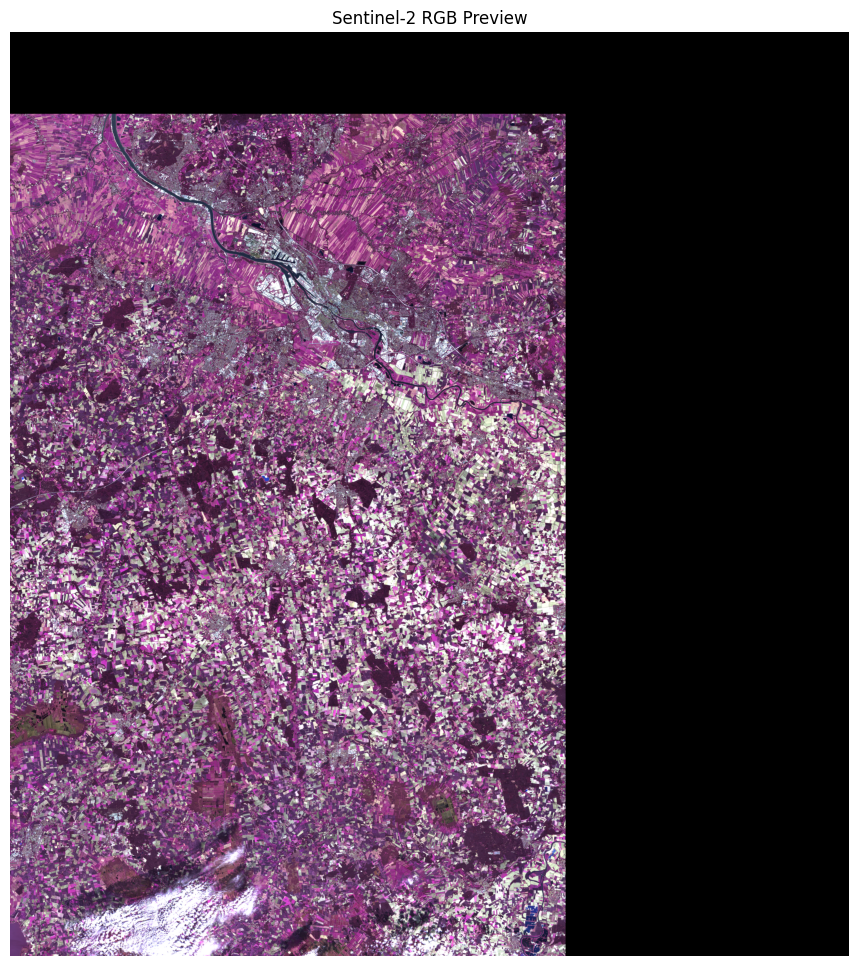

RGB preview saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/processed_data/sentinel2_rgb_preview.png
Resampling data to 5490x5490...
Resampled shape: (10, 5490, 5490)
New transform: | 15.01, 0.00, 455180.00|
| 0.00,-16.54, 5908080.00|
| 0.00, 0.00, 1.00|
Final shape (HWC): (5490, 5490, 10)
Resampled S2 data saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/processed_data/sentinel2_resampled.tif


In [47]:
# Process the downloaded Sentinel-2 data
s2_filepath = "/content/drive/MyDrive/0_PrototypeFund_Project/sentinel2_germany_region_20210909.tif"
s2_data, s2_profile = process_sentinel2_data(s2_filepath)


Processing Sentinel-1 data from: /content/drive/MyDrive/0_PrototypeFund_Project/sentinel1_germany_region_20210909.tif
Using Sentinel-2 B4 (Red band) as reference for coregistration
Band count: 2
Dimensions: 4121 x 4540
Resolution: (20.0, 20.0)
CRS: EPSG:32632
S1 Transform: | 20.00, 0.00, 455180.00|
| 0.00,-20.00, 5908080.00|
| 0.00, 0.00, 1.00|
S1 CRS: EPSG:32632
S1 Bounds: BoundingBox(left=455180.0, bottom=5817280.0, right=537600.0, top=5908080.0)


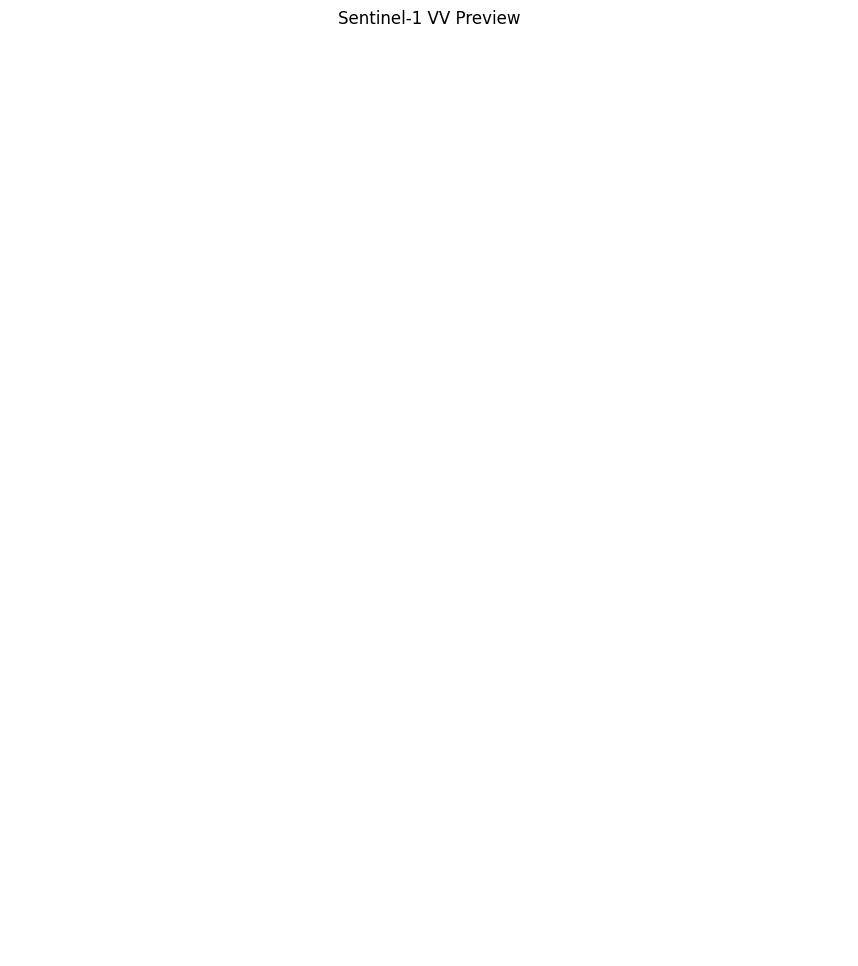

VV preview saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/processed_data/sentinel1_vv_preview.png
Using Sentinel-2 B4 as reference. Shape: (5490, 5490)
Co-registering S1 data to match S2 B4...
Resampled shape: (2, 5490, 5490)
Final shape (HWC): (5490, 5490, 2)
Coregistered S1 data saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/processed_data/sentinel1_coregistered_2021-09-09.tif


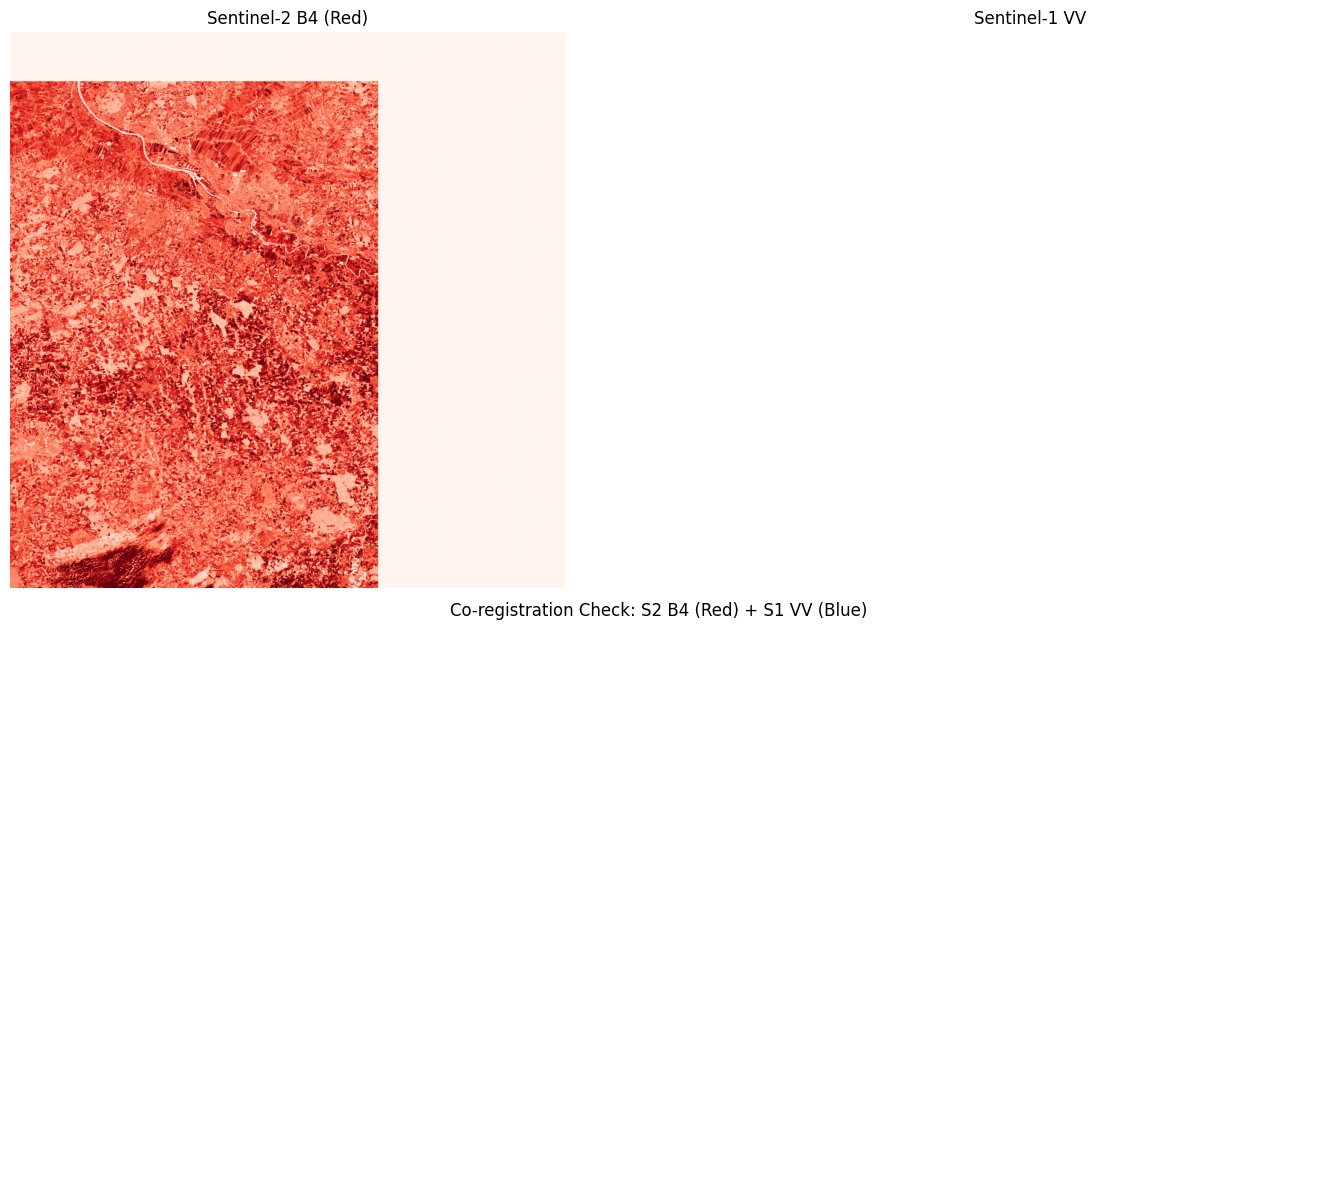

Co-registration verification image saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/processed_data/s1_s2_coregistration_check.png
In the co-registration check image:
  - Red areas indicate features visible in S2 B4 but not in S1 VV
  - Blue areas indicate features visible in S1 VV but not in S2 B4
  - Purple areas indicate where both images align with similar intensity


In [48]:
# Process the downloaded Sentinel-1 data, using S2 B4 as reference
s1_filepath = "/content/drive/MyDrive/0_PrototypeFund_Project/sentinel1_germany_region_20210909.tif"
s1_data, s1_coregistered_path = process_sentinel1_data(s1_filepath, s2_profile, s2_data)

Processing reference mask from: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/Europe_Mask.tif
Dimensions: 15000 x 15000
Resolution: (0.00032862895973333336, 0.00017217895406666675)
CRS: EPSG:4326
Reference mask transform: | 0.00, 0.00, 6.67|
| 0.00,-0.00, 53.89|
| 0.00, 0.00, 1.00|
Reference mask bounds: BoundingBox(left=6.668792572, bottom=51.303957565, right=11.598226968, top=53.886641876)
Unique values in mask: [  0  43  44  62  66  67  68  78  79  84  91 148 159 171 175 179 186 194
 197 215 216 217 218 223 225 226 227 230 232 233 234 235 236 237 238 249
 253 254]


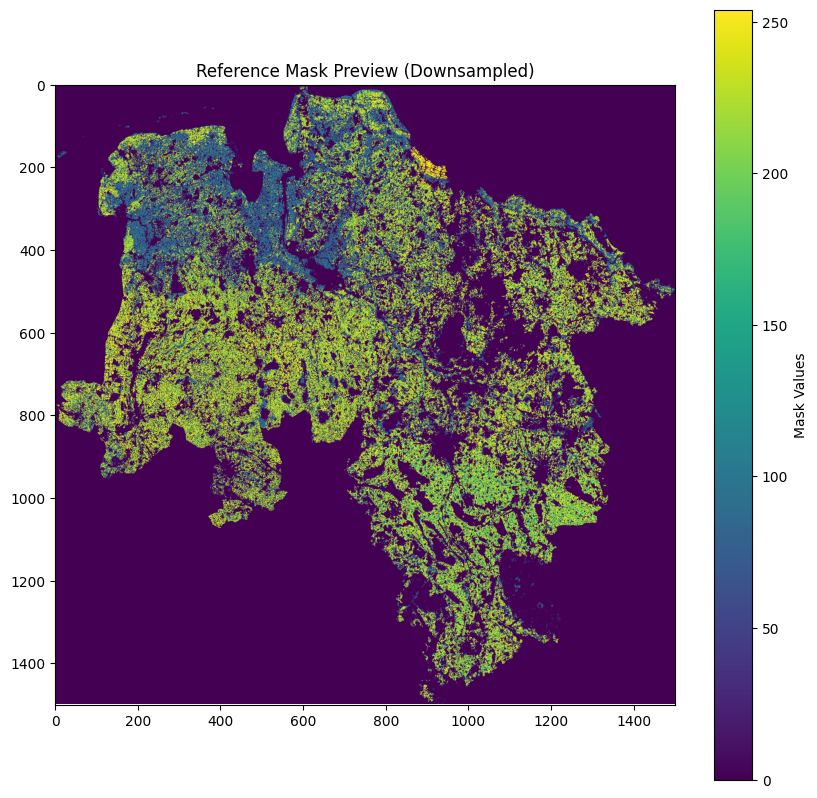

Reprojecting reference mask to match S2 spatial reference...


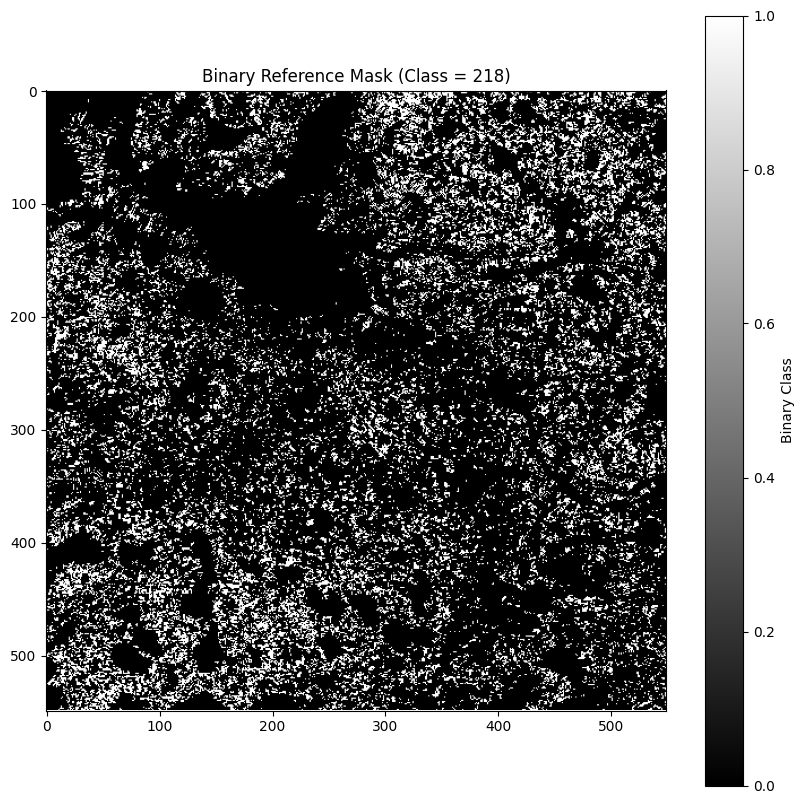

Percentage of positive (class=1) pixels: 17.20%
Co-registered binary mask saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/processed_data/reference_mask_coregistered.tif


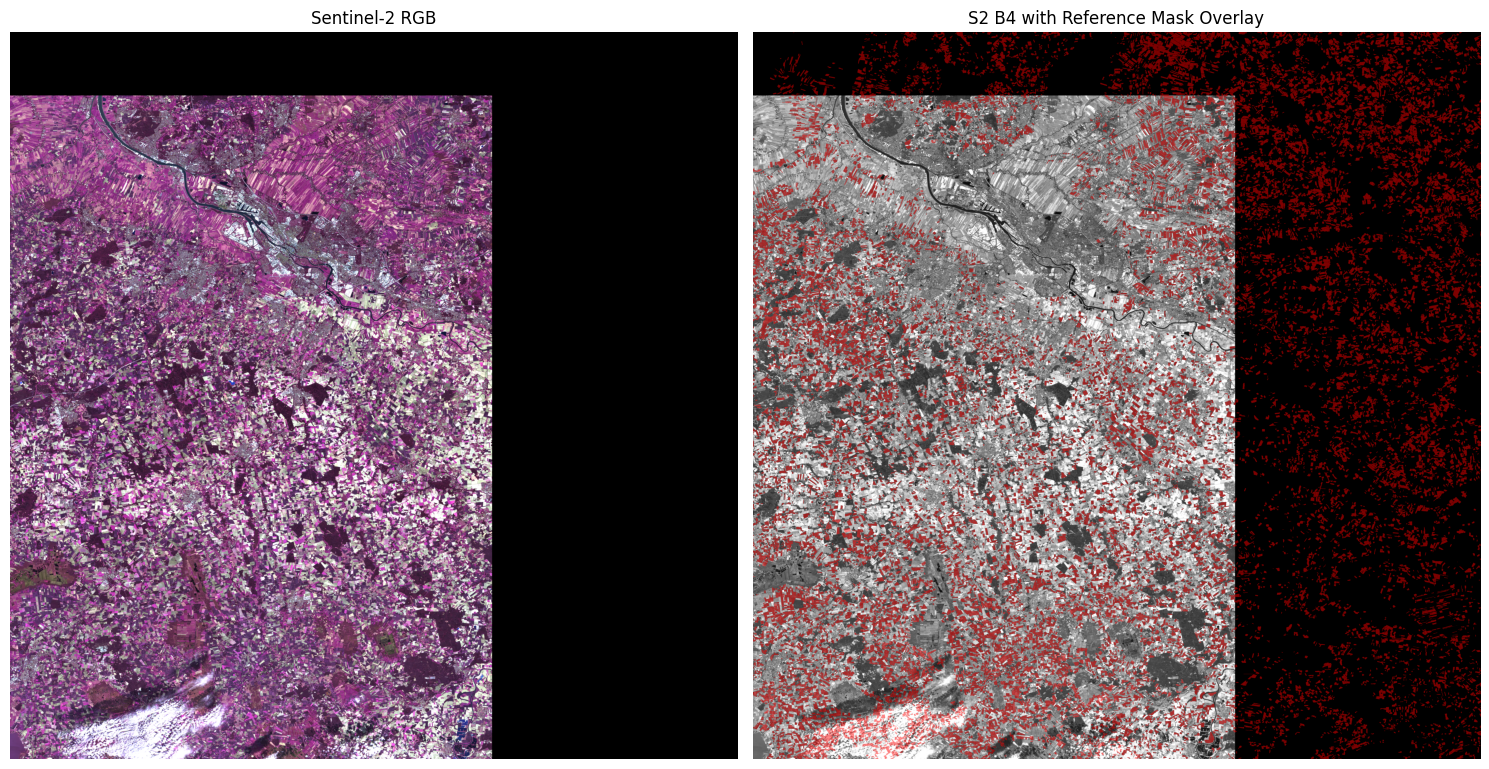

In [49]:
# Process the reference mask with S2 data for visualization and correlation
reference_mask, ref_coregistered_path = process_reference_mask(europe_mask_path, s2_profile, s2_data)

## 6. Combine Data and Export Numpy Arrays

Combining and exporting data arrays...
Original Data shape
S2 data shape: (5490, 5490, 10)
S1 data shape: (5490, 5490, 2)
Reference mask shape: (5490, 5490)
Data shape after removing blank areas
(4990, 2300, 12)
(4990, 2300)


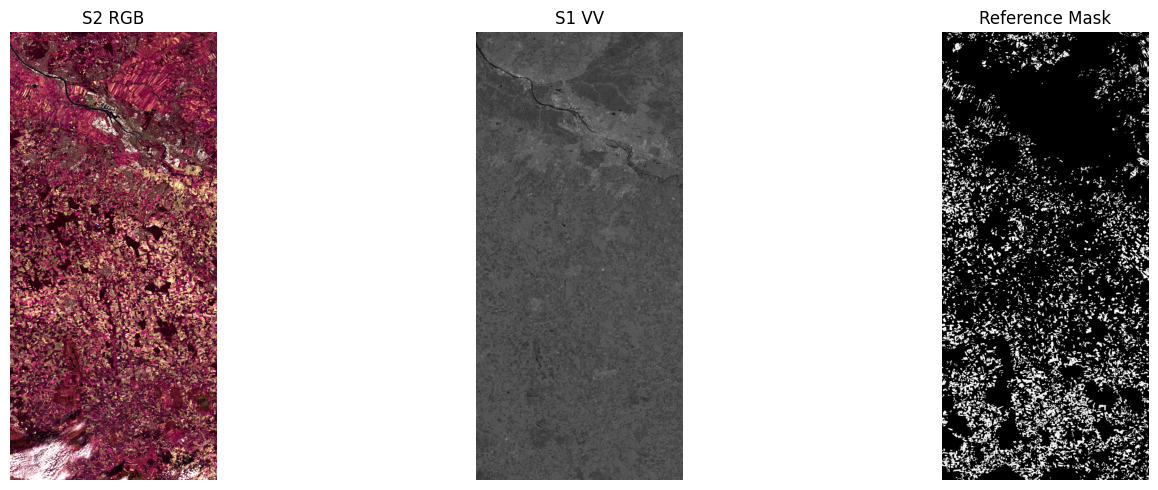

Combined array saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/numpy_arrays/sentinel_combined_germany_region.npy
Reference mask saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/numpy_arrays/reference_germany_region.npy


In [50]:
def combine_and_export_arrays(s2_data, s1_data, reference_mask):
    """Combine Sentinel-1 and Sentinel-2 data and export as numpy arrays"""
    print("Combining and exporting data arrays...")
    print('Original Data shape')
    # Verify all data is properly co-registered by checking shapes
    print(f"S2 data shape: {s2_data.shape}")
    print(f"S1 data shape: {s1_data.shape}")
    print(f"Reference mask shape: {reference_mask.shape}")

    # Check that the spatial dimensions match
    assert s2_data.shape[0] == s1_data.shape[0] == reference_mask.shape[0], "Height dimensions don't match!"
    assert s2_data.shape[1] == s1_data.shape[1] == reference_mask.shape[1], "Width dimensions don't match!"

    # Combine S1 and S2 data along the channel dimension
    combined_data = np.concatenate([s2_data, s1_data], axis=-1)
    ###############
    ##Cutting part of the images which are blank
    combined_data = combined_data[500:5490,700:3000,:]
    reference_mask = reference_mask[500:5490,700:3000]

    print('Data shape after removing blank areas')
    print(combined_data.shape)
    print(reference_mask.shape)
    ###############



    # Create a visualization of the combined data
    plt.figure(figsize=(16, 5))

    # Show S2 RGB
    plt.subplot(131)
    rgb = np.stack([
        combined_data[:, :, 3],  # Red - B4
        combined_data[:, :, 2],  # Green - B3
        combined_data[:, :, 1]   # Blue - B2
    ], axis=-1)
    rgb_norm = np.clip((rgb - np.percentile(rgb, 2)) /
                       (np.percentile(rgb, 98) - np.percentile(rgb, 2)), 0, 1)
    plt.imshow(rgb_norm)
    plt.title("S2 RGB")
    plt.axis('off')

    # Show S1 VV band
    plt.subplot(132)
    vv = combined_data[:, :, 10]
    plt.imshow(vv, cmap='gray')
    plt.title("S1 VV")
    plt.axis('off')

    # Show mask
    plt.subplot(133)
    plt.imshow(reference_mask, cmap='gray')
    plt.title("Reference Mask")
    plt.axis('off')

    plt.tight_layout()
    combined_preview_path = os.path.join(OUTPUT_DIR, "processed_data", "combined_data_preview.png")
    plt.savefig(combined_preview_path, dpi=150)
    plt.show()


    # Save arrays
    combined_file = os.path.join(OUTPUT_DIR, "numpy_arrays", f"sentinel_combined_{ROI_NAME}.npy")
    np.save(combined_file, combined_data)
    print(f"Combined array saved to: {combined_file}")

    reference_file = os.path.join(OUTPUT_DIR, "numpy_arrays", f"reference_{ROI_NAME}.npy")
    np.save(reference_file, reference_mask)
    print(f"Reference mask saved to: {reference_file}")

    return combined_file, reference_file

# Combine and export arrays
combined_file, reference_file = combine_and_export_arrays(s2_data, s1_data, reference_mask)

## 7. Tile Data for Machine Learning

In [51]:
def tile_data(data_array, patch_size=PATCH_SIZE, step=PATCH_SIZE):
    """Tile image data using patchify"""
    print(f"Tiling combined data into {patch_size}x{patch_size} patches...")

    # Apply patchify
    patches = patchify(data_array, (patch_size, patch_size, data_array.shape[2]), step=step)

    # Reshape to list of patches
    n_h, n_w = patches.shape[0], patches.shape[1]
    n_patches = n_h * n_w
    patches_reshaped = patches.reshape(n_patches, patch_size, patch_size, data_array.shape[2])

    # Apply MinMaxScaler to normalize each patch
    print("Normalizing patches with MinMaxScaler...")
    minmaxscaler = MinMaxScaler()
    normalized_patches = np.zeros_like(patches_reshaped, dtype=np.float32)

    for i in range(n_patches):
        if i % 100 == 0:
            print(f"Processing patch {i}/{n_patches}...")

        patch = patches_reshaped[i]
        # Reshape to 2D for scaling
        patch_2d = patch.reshape(-1, patch.shape[-1])
        normalized = minmaxscaler.fit_transform(patch_2d)
        # Reshape back to original dimensions
        normalized_patches[i] = normalized.reshape(patch.shape)

    # Save patches
    patches_file = os.path.join(OUTPUT_DIR, "patches", f"sentinel_patches_{ROI_NAME}.npy")
    np.save(patches_file, normalized_patches)

    print(f"Created {n_patches} patches ({n_h}x{n_w} grid)")
    print(f"Patches saved to: {patches_file}")

    # Save the patch grid dimensions for later reference
    patch_info = {
        'n_rows': n_h,
        'n_cols': n_w,
        'total_patches': n_patches,
        'patch_size': patch_size,
        'step_size': step
    }

    patch_info_file = os.path.join(OUTPUT_DIR, "patches", "patch_grid_info.json")
    with open(patch_info_file, 'w') as f:
        json.dump(patch_info, f, indent=2)

    print(f"Patch grid info saved to: {patch_info_file}")

    return patches_file, normalized_patches, patch_info


In [52]:
def tile_reference_data(mask_array, patch_size=PATCH_SIZE, step=PATCH_SIZE, patch_info=None):
    """Tile reference mask using patchify"""
    print(f"Tiling reference mask into {patch_size}x{patch_size} patches...")

    # Apply patchify
    patches = patchify(mask_array, (patch_size, patch_size), step=step)

    # Reshape to list of patches
    n_h, n_w = patches.shape[0], patches.shape[1]
    n_patches = n_h * n_w

    # Verify patch dimensions match with the image patches if patch_info is provided
    if patch_info is not None:
        expected_rows = patch_info['n_rows']
        expected_cols = patch_info['n_cols']
        if n_h != expected_rows or n_w != expected_cols:
            print(f"WARNING: Reference mask patch grid ({n_h}x{n_w}) doesn't match"
                  f" image patch grid ({expected_rows}x{expected_cols})!")

    patches_reshaped = patches.reshape(n_patches, patch_size, patch_size)

    # Save patches
    patches_file = os.path.join(OUTPUT_DIR, "patches", f"reference_patches_{ROI_NAME}.npy")
    np.save(patches_file, patches_reshaped)

    print(f"Created {n_patches} mask patches ({n_h}x{n_w} grid)")
    print(f"Patches saved to: {patches_file}")

    return patches_file, patches_reshaped


In [53]:
# Tile the combined data
combined_data = np.load(combined_file)
image_patches_file, image_patches, patch_info = tile_data(combined_data)

Tiling combined data into 128x128 patches...
Normalizing patches with MinMaxScaler...
Processing patch 0/646...
Processing patch 100/646...
Processing patch 200/646...
Processing patch 300/646...
Processing patch 400/646...
Processing patch 500/646...
Processing patch 600/646...
Created 646 patches (38x17 grid)
Patches saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/sentinel_patches_germany_region.npy
Patch grid info saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/patch_grid_info.json


In [54]:
# Tile the reference mask
reference_data = np.load(reference_file)
reference_patches_file, reference_patches = tile_reference_data(reference_data, patch_info=patch_info)

Tiling reference mask into 128x128 patches...
Created 646 mask patches (38x17 grid)
Patches saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/reference_patches_germany_region.npy


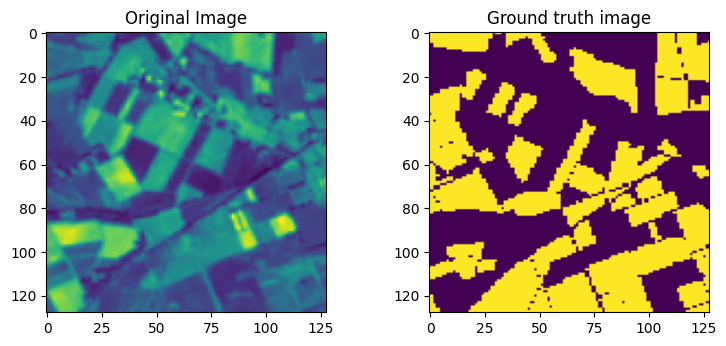

In [55]:
index=553
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(image_patches[index,:,:,3])
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(reference_patches[index,:,: ])


## 8. Visualize Sample Patches

Visualizing 5 random sample patches...
Image patches shape: (646, 128, 128, 12)
Reference patches shape: (646, 128, 128)
Patch #492 shape: (128, 128, 12)
RGB stack shape: (128, 128, 3)
Patch #562 shape: (128, 128, 12)
RGB stack shape: (128, 128, 3)
Patch #27 shape: (128, 128, 12)
RGB stack shape: (128, 128, 3)
Patch #305 shape: (128, 128, 12)
RGB stack shape: (128, 128, 3)
Patch #293 shape: (128, 128, 12)
RGB stack shape: (128, 128, 3)


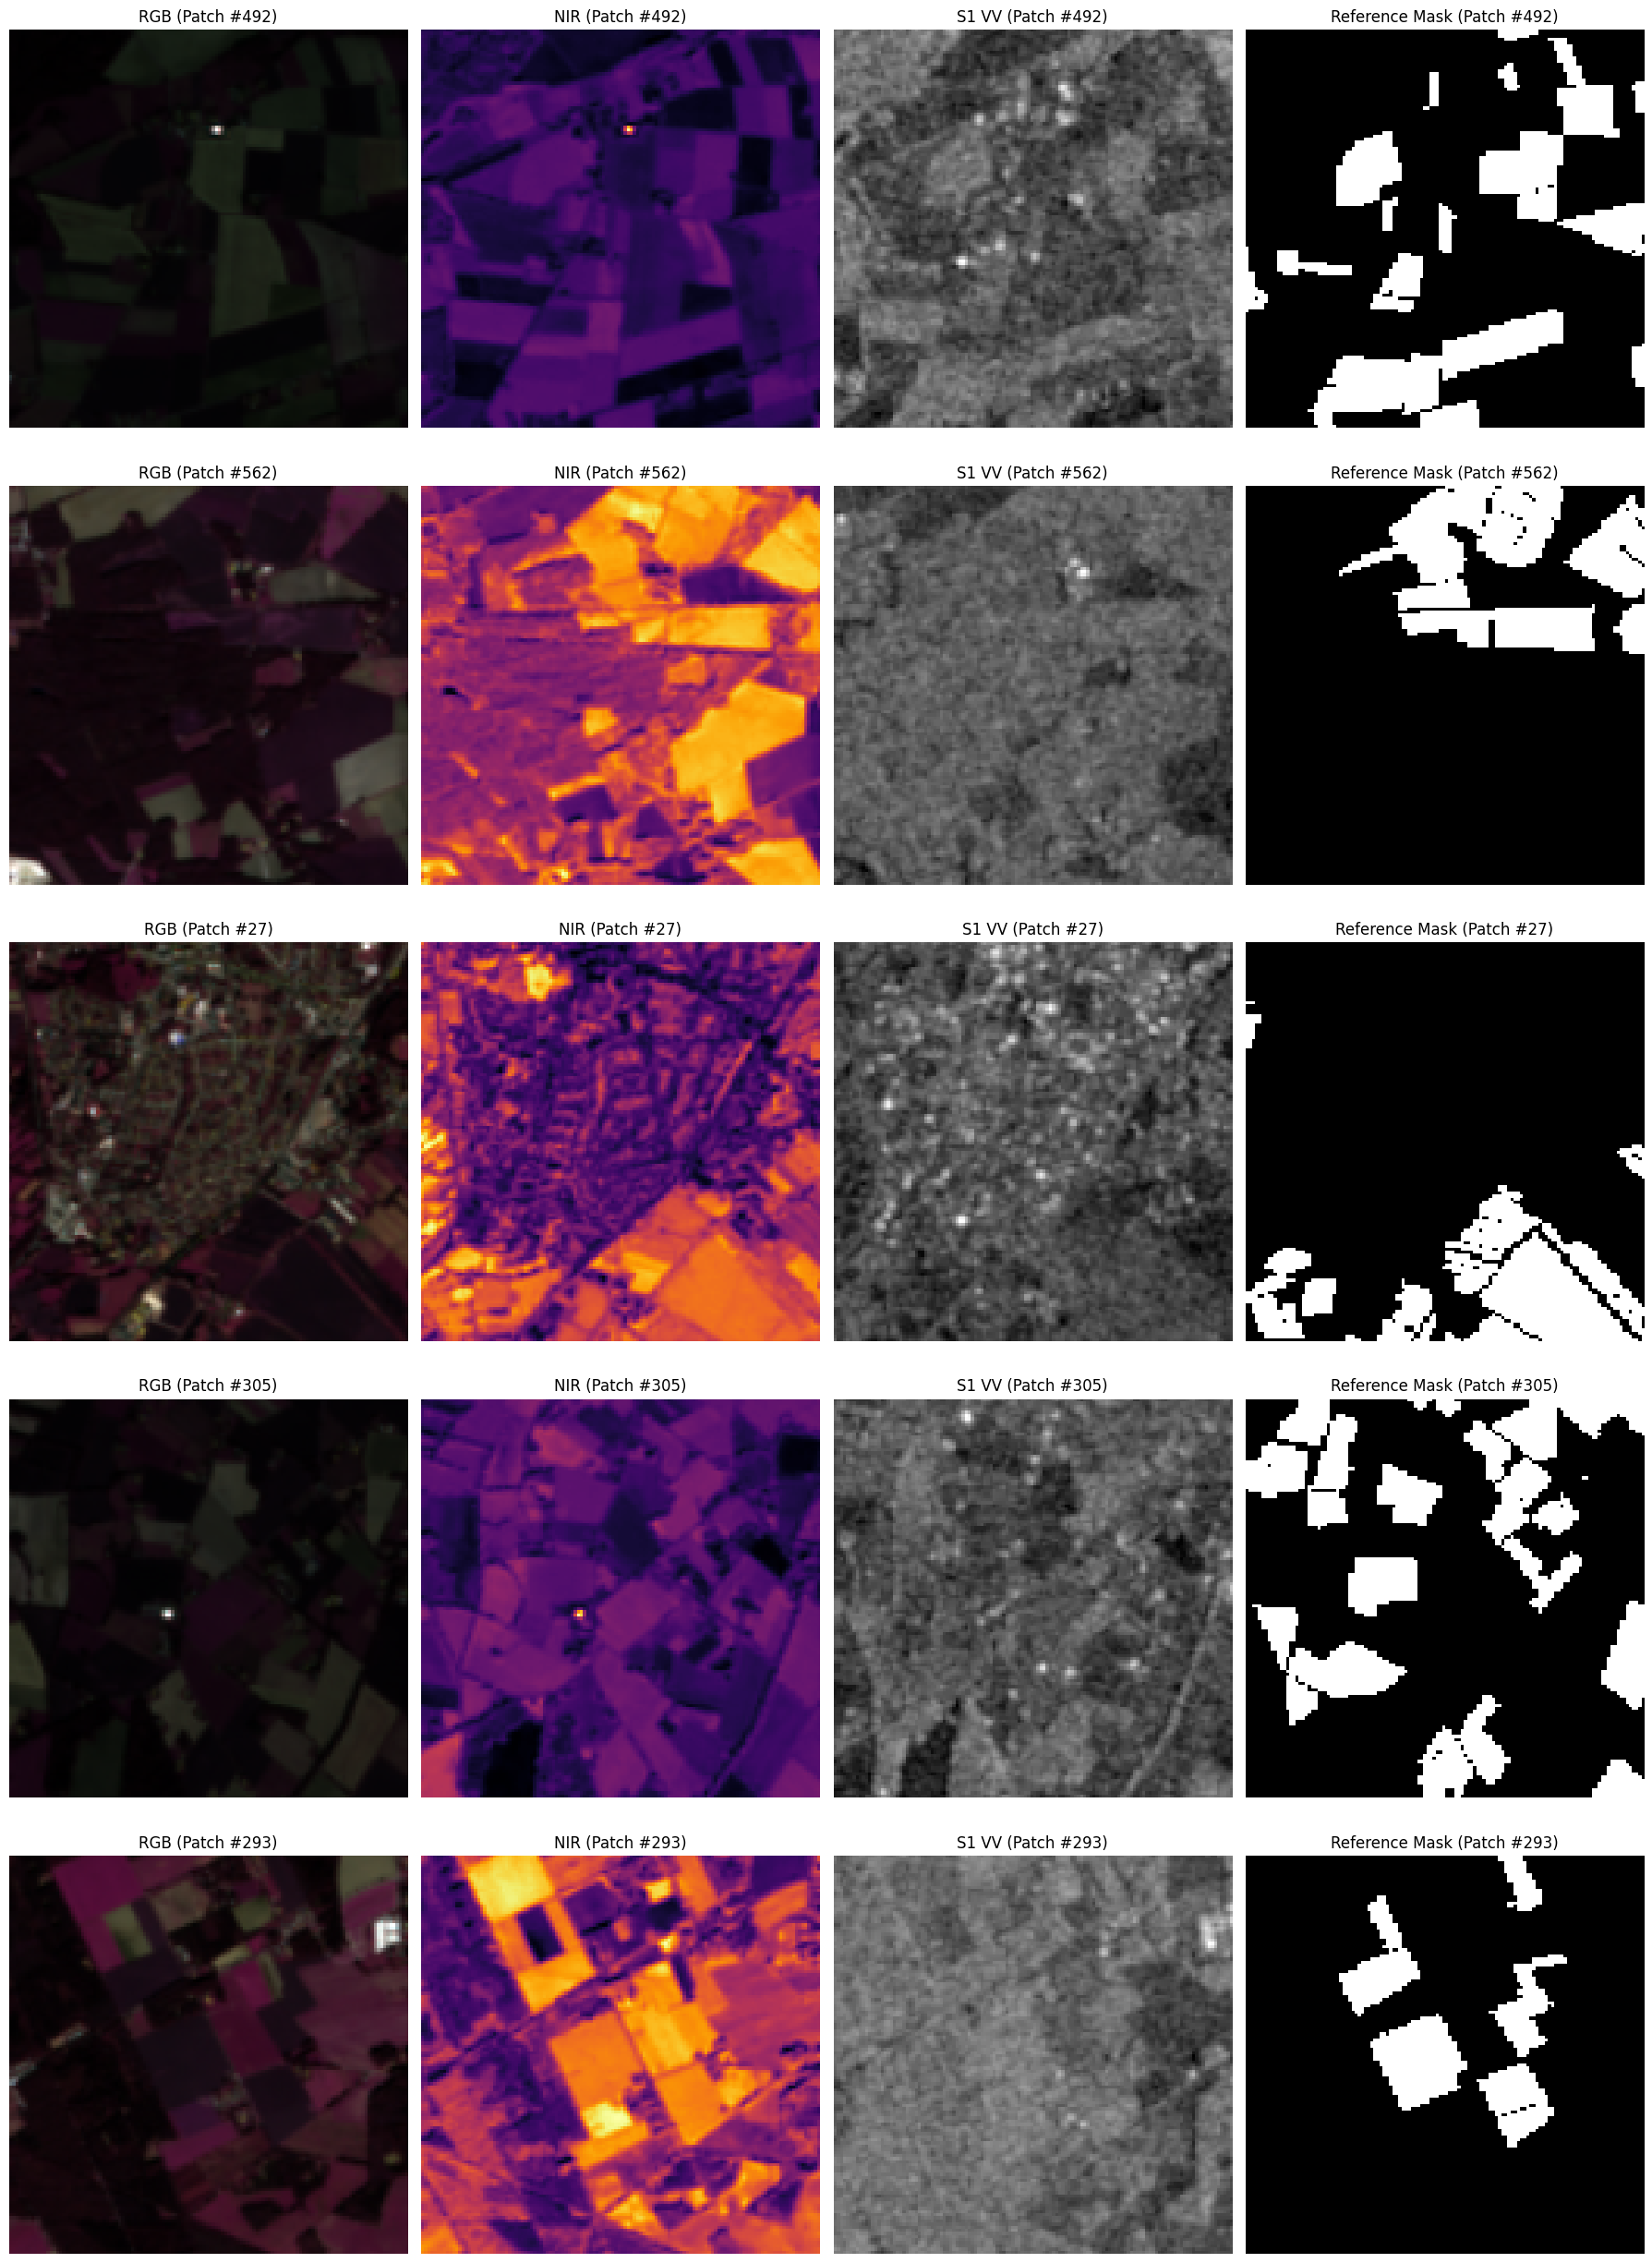

Sample visualization saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/sample_patches_visualization.png


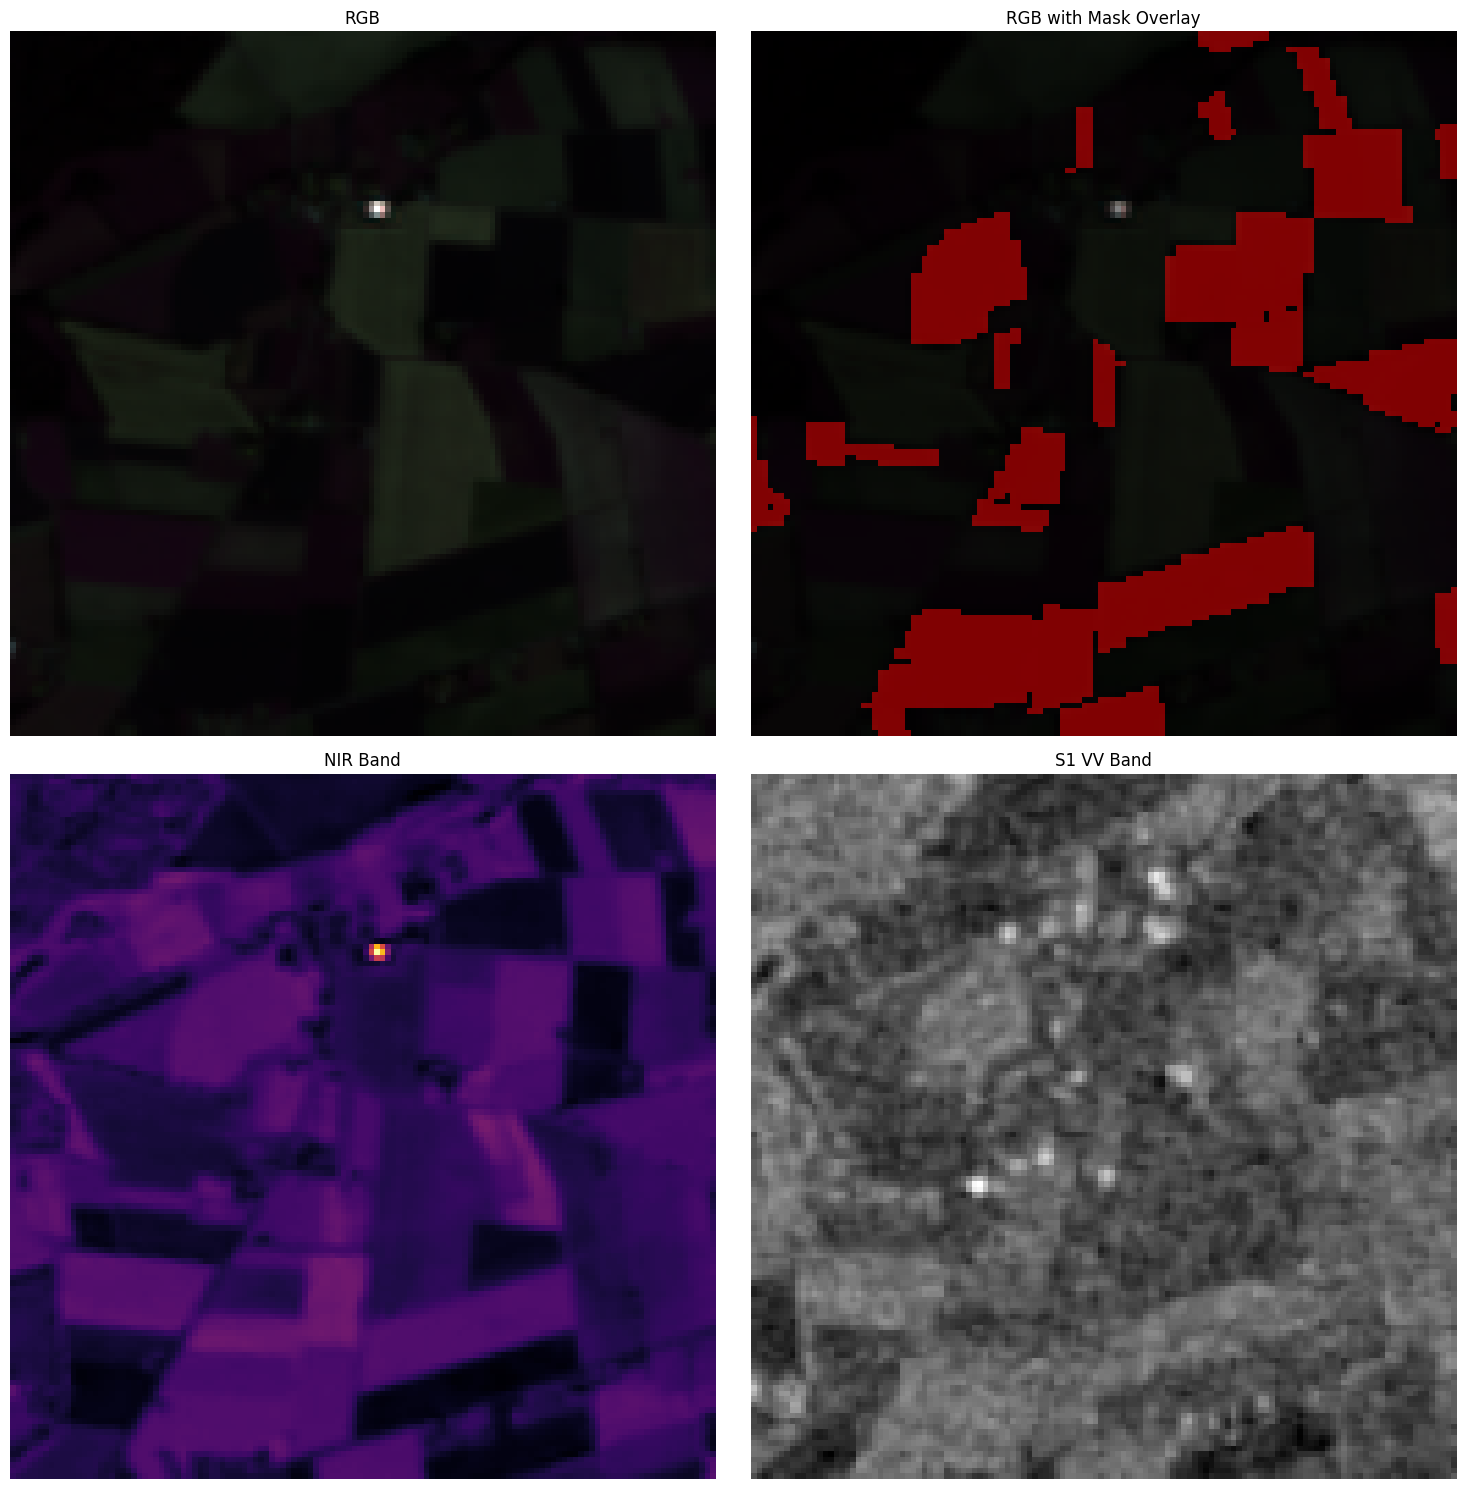

Mask overlay visualization saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/mask_overlay_visualization.png


In [56]:
def visualize_sample_patches(image_patches, reference_patches, num_samples=5):
    """Visualize sample patches with their corresponding reference masks"""
    print(f"Visualizing {num_samples} random sample patches...")

    # Check the shape of image patches
    print(f"Image patches shape: {image_patches.shape}")
    print(f"Reference patches shape: {reference_patches.shape}")

    # Select random indices
    if len(image_patches) < num_samples:
        num_samples = len(image_patches)
        indices = range(num_samples)
    else:
        indices = np.random.choice(len(image_patches), num_samples, replace=False)

    plt.figure(figsize=(18, num_samples * 5))

    for i, idx in enumerate(indices):
        # Get the patch
        patch = image_patches[idx]
        print(f"Patch #{idx} shape: {patch.shape}")

        # Display RGB image (S2)
        plt.subplot(num_samples, 4, i*4+1)
        plt.title(f"RGB (Patch #{idx})")

        # Extract RGB bands (manually ensuring correct shape)
        r_band = patch[:, :, 3]  # Red band
        g_band = patch[:, :, 2]  # Green band
        b_band = patch[:, :, 1]  # Blue band

        # Stack them correctly for RGB display
        rgb = np.stack([r_band, g_band, b_band], axis=-1)
        print(f"RGB stack shape: {rgb.shape}")

        # Normalize for display
        rgb_norm = np.zeros_like(rgb, dtype=np.float32)
        for j in range(3):
            min_val = np.min(rgb[:,:,j])
            max_val = np.max(rgb[:,:,j])
            if max_val > min_val:
                rgb_norm[:,:,j] = (rgb[:,:,j] - min_val) / (max_val - min_val)
            else:
                rgb_norm[:,:,j] = 0

        plt.imshow(rgb_norm)
        plt.axis('off')

        # Display NIR false color (S2)
        plt.subplot(num_samples, 4, i*4+2)
        plt.title(f"NIR (Patch #{idx})")

        # Display NIR band
        nir_band = patch[:, :, 7]  # NIR band (B8)
        plt.imshow(nir_band, cmap='inferno')
        plt.axis('off')

        # Display S1 (VV band)
        plt.subplot(num_samples, 4, i*4+3)
        plt.title(f"S1 VV (Patch #{idx})")

        # Total bands from Sentinel-2 is 12, so VV should be at index 12
        vv_band = patch[:, :, 10]  # VV band from S1
        plt.imshow(vv_band, cmap='gray')
        plt.axis('off')

        # Display reference mask
        plt.subplot(num_samples, 4, i*4+4)
        plt.title(f"Reference Mask (Patch #{idx})")
        plt.imshow(reference_patches[idx], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    vis_file = os.path.join(OUTPUT_DIR, "patches", "sample_patches_visualization.png")
    plt.savefig(vis_file, dpi=150)
    plt.show()

    print(f"Sample visualization saved to: {vis_file}")

    # Create a figure showing the correspondence between the mask and satellite data
    plt.figure(figsize=(15, 15))

    # Select a single patch that has a good mix of positive and negative pixels
    good_samples = []
    for idx in indices:
        mask = reference_patches[idx]
        positive_percentage = np.sum(mask > 0) / mask.size * 100
        if 20 < positive_percentage < 80:
            good_samples.append(idx)

    if good_samples:
        sample_idx = good_samples[0]
    else:
        sample_idx = indices[0]

    patch = image_patches[sample_idx]
    mask = reference_patches[sample_idx]

    # Extract bands
    r_band = patch[:, :, 3]
    g_band = patch[:, :, 2]
    b_band = patch[:, :, 1]
    nir_band = patch[:, :, 7]
    vv_band = patch[:, :, 10]

    # RGB image
    rgb = np.stack([r_band, g_band, b_band], axis=-1)
    rgb_norm = np.zeros_like(rgb, dtype=np.float32)
    for j in range(3):
        min_val = np.min(rgb[:,:,j])
        max_val = np.max(rgb[:,:,j])
        if max_val > min_val:
            rgb_norm[:,:,j] = (rgb[:,:,j] - min_val) / (max_val - min_val)
        else:
            rgb_norm[:,:,j] = 0

    # Create overlay
    plt.subplot(221)
    plt.imshow(rgb_norm)
    plt.title("RGB")
    plt.axis('off')

    plt.subplot(222)
    plt.imshow(rgb_norm)
    mask_overlay = np.zeros_like(rgb_norm)
    mask_overlay[:, :, 0] = mask * 1.0  # Red channel only
    plt.imshow(mask_overlay, alpha=0.5)
    plt.title("RGB with Mask Overlay")
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(nir_band, cmap='inferno')
    plt.title("NIR Band")
    plt.axis('off')

    plt.subplot(224)
    plt.imshow(vv_band, cmap='gray')
    plt.title("S1 VV Band")
    plt.axis('off')

    plt.tight_layout()
    overlay_file = os.path.join(OUTPUT_DIR, "patches", "mask_overlay_visualization.png")
    plt.savefig(overlay_file, dpi=150)
    plt.show()

    print(f"Mask overlay visualization saved to: {overlay_file}")

    return vis_file

# Visualize sample patches
vis_file = visualize_sample_patches(image_patches, reference_patches, num_samples=5)

## 9. Calculate Class Distribution in Patches

Analyzing class distribution in reference patches...
Class distribution in patches:
  Mean positive percentage: 15.37%
  Median positive percentage: 14.08%
  Min positive percentage: 0.00%
  Max positive percentage: 53.16%


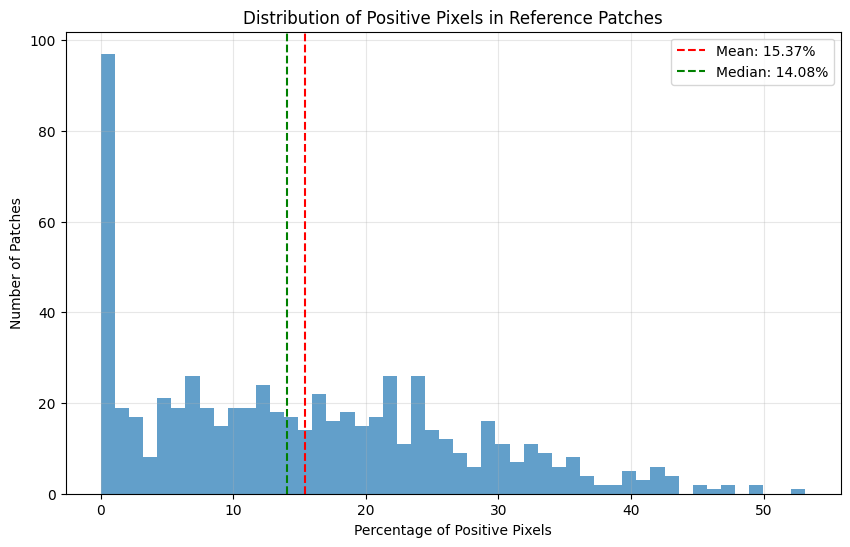

Class distribution histogram saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/class_distribution_histogram.png
Patches with no positive pixels: 68 (10.53%)
Patches with all positive pixels: 0 (0.00%)


In [57]:
def analyze_class_distribution(reference_patches):
    """Analyze the class distribution in the reference patches"""
    print("Analyzing class distribution in reference patches...")

    # Calculate percentage of positive pixels in each patch
    positive_percentages = []

    for i in range(len(reference_patches)):
        patch = reference_patches[i]
        positive_percentage = (patch > 0).sum() / patch.size * 100
        positive_percentages.append(positive_percentage)

    # Convert to numpy array
    positive_percentages = np.array(positive_percentages)

    # Calculate summary statistics
    mean_percentage = np.mean(positive_percentages)
    median_percentage = np.median(positive_percentages)
    min_percentage = np.min(positive_percentages)
    max_percentage = np.max(positive_percentages)

    print(f"Class distribution in patches:")
    print(f"  Mean positive percentage: {mean_percentage:.2f}%")
    print(f"  Median positive percentage: {median_percentage:.2f}%")
    print(f"  Min positive percentage: {min_percentage:.2f}%")
    print(f"  Max positive percentage: {max_percentage:.2f}%")

    # Create histogram of positive percentages
    plt.figure(figsize=(10, 6))
    plt.hist(positive_percentages, bins=50, alpha=0.7)
    plt.axvline(mean_percentage, color='red', linestyle='--', label=f'Mean: {mean_percentage:.2f}%')
    plt.axvline(median_percentage, color='green', linestyle='--', label=f'Median: {median_percentage:.2f}%')
    plt.xlabel('Percentage of Positive Pixels')
    plt.ylabel('Number of Patches')
    plt.title('Distribution of Positive Pixels in Reference Patches')
    plt.legend()
    plt.grid(alpha=0.3)

    hist_file = os.path.join(OUTPUT_DIR, "patches", "class_distribution_histogram.png")
    plt.savefig(hist_file, dpi=150)
    plt.show()

    print(f"Class distribution histogram saved to: {hist_file}")

    # Count patches with no positive pixels
    empty_patches = np.sum(positive_percentages == 0)
    empty_percentage = empty_patches / len(positive_percentages) * 100
    print(f"Patches with no positive pixels: {empty_patches} ({empty_percentage:.2f}%)")

    # Count patches with all positive pixels
    full_patches = np.sum(positive_percentages == 100)
    full_percentage = full_patches / len(positive_percentages) * 100
    print(f"Patches with all positive pixels: {full_patches} ({full_percentage:.2f}%)")

    return positive_percentages

# Analyze class distribution
positive_percentages = analyze_class_distribution(reference_patches)

## 11. Save Dataset Information

In [58]:
def save_dataset_info():
    """Save information about the processed dataset"""
    info = {
        "sentinel2_date": s2_date,
        "sentinel1_date": s1_date,
        "roi_name": ROI_NAME,
        "patch_size": PATCH_SIZE,
        "image_size": IMG_SIZE,
        "image_resolution": TARGET_RESOLUTION,
        "s2_bands": ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"],
        "s1_bands": ["VV", "VH"],
        "combined_shape": combined_data.shape,
        "reference_shape": reference_data.shape,
        "num_patches": len(image_patches),
        "patch_shape": image_patches[0].shape,
        "reference_patch_shape": reference_patches[0].shape,
        "positive_percentage_overall": reference_data.sum() / reference_data.size * 100,
        "class_value": 218,  # The value used for creating binary mask
        "processing_date": datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    # Save as JSON
    info_file = os.path.join(OUTPUT_DIR, "dataset_info.json")
    with open(info_file, 'w') as f:
        json.dump(info, f, indent=2)

    print(f"Dataset information saved to: {info_file}")

    # Print summary
    print("\nDataset Summary:")
    print("=" * 50)
    print(f"Sentinel-2 Date: {info['sentinel2_date']}")
    print(f"Sentinel-1 Date: {info['sentinel1_date']}")
    print(f"ROI: {info['roi_name']}")
    print(f"Combined Data Shape: {info['combined_shape']}")
    print(f"Reference Mask Shape: {info['reference_shape']}")
    print(f"Number of Patches: {info['num_patches']}")
    print(f"Patch Size: {info['patch_size']}x{info['patch_size']}")
    print(f"Overall Positive Percentage: {info['positive_percentage_overall']:.2f}%")
    print("=" * 50)

    return info_file

# Save dataset info
info_file = save_dataset_info()

Dataset information saved to: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/dataset_info.json

Dataset Summary:
Sentinel-2 Date: 2021-09-09
Sentinel-1 Date: 2021-09-09
ROI: germany_region
Combined Data Shape: (4990, 2300, 12)
Reference Mask Shape: (4990, 2300)
Number of Patches: 646
Patch Size: 128x128
Overall Positive Percentage: 15.51%


## 12. Summary and Next Steps

In [59]:
print("\nSentinel Data Processing Pipeline - Complete!")
print("=" * 50)
print("\nAll data has been processed and saved to:")
print(f"  Base Path: {BASE_PATH}")
print(f"  Input Directory: {INPUT_DIR}")
print(f"  Output Directory: {OUTPUT_DIR}")

print("\nKey Output Files:")
print(f"  Combined Data Array: {combined_file}")
print(f"  Reference Mask Array: {reference_file}")
print(f"  Image Patches: {image_patches_file}")
print(f"  Reference Patches: {reference_patches_file}")
print(f"  Dataset Info: {info_file}")

print("\nNext Steps:")
print("  1. The prepared data can now be used for training a U-Net or similar model")
print("  2. Follow Next tutorial to build the model")
print("  3. Apply the trained model to new Sentinel imagery for land cover classification")


Sentinel Data Processing Pipeline - Complete!

All data has been processed and saved to:
  Base Path: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset
  Input Directory: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset
  Output Directory: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data

Key Output Files:
  Combined Data Array: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/numpy_arrays/sentinel_combined_germany_region.npy
  Reference Mask Array: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/numpy_arrays/reference_germany_region.npy
  Image Patches: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/sentinel_patches_germany_region.npy
  Reference Patches: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/patches/reference_patches_germany_region.npy
  Dataset Info: /content/drive/MyDrive/0_PrototypeFund_Project/0_Dataset/output_data/dataset_info.json

Next Steps